# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

---

## Generate small toy example dataset


In [406]:
# Define random parameters
dim = 2  # Dimensionality of the process
mu = torch.tensor([0.3, 0.1])
beta = torch.tensor([
    [1.0, 0.2],
    [0.5, 0.1]
])
# Use the same constraint as GrangerBusca to allow fair comparison
alpha = torch.tensor([
    [0.7, 0.3],
    [0.0, 1.0]
])
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=5, seed=None)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
print("      - dim 0:", events[0])
print("      - dim 1:", events[1])

  - Simulate lots of data...
    - Simulated 5 events with end time: 12.8433198928833
    - Events:
      - dim 0: tensor([ 2.6477, 12.1833])
      - dim 1: tensor([ 7.4478,  8.8120, 12.8433])


---

## Test Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Create model object and set the data.

In [4]:
# Set model
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

Define the parameters of the prior.

In [66]:
# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))
# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))
# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

---

In [42]:
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)
model._init_fit(as_pr, ar_pr, bs_pr, br_pr, zc_pr)

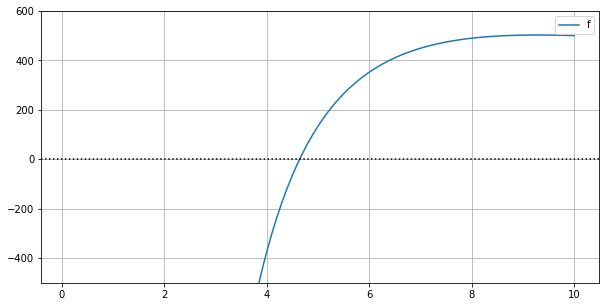

In [57]:
kwargs = {'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
          'as_po': model._as_po, 'ar_po': model._ar_po, 
          'zp_po': model._zp_po, 'dts': model.dt_ik, 
          'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj}

x = np.linspace(0.1, 10.0, 100)
j=0
i=1
n=0
y = [tsvar.models._wold_var.func(e, j=j, i=i, n=n, **kwargs) for e in x]
dy = [tsvar.models._wold_var.fprime(e, j=j, i=i, n=n, **kwargs) for e in x]
ddy = [tsvar.models._wold_var.fprime2(e, j=j, i=i, n=n, **kwargs) for e in x]

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x, y, label='f')
#plt.plot(x, dy, label="f'")
#plt.plot(x, ddy, c='r')
plt.legend()
plt.ylim(-500.0, 600.0)
plt.axhline(0.0, c='k', ls=':')

In [51]:
kwargs = {
    'j': 1, 'i': 0, 'n': 5,
    'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
    'as_po': model._as_po, 'ar_po': model._ar_po, 
    'zp_po': model._zp_po, 'dts': model.dt_ik, 
    'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj
}

x0 = 2.0

tsvar.models._wold_var.solve_halley(
    tsvar.models._wold_var.func,
    tsvar.models._wold_var.fprime,
    tsvar.models._wold_var.fprime2,
    x0,
    max_iter=100,
    tol=1e-5,
    **kwargs)

(4.2898279234379935, True)

In [231]:
kwargs = {
    'as_po': model._as_po, 'ar_po': model._ar_po, 
    'zp_po': model._zp_po, 
    'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
    'dt_ik': model.dt_ik, 'delta_ikj': model.delta_ikj, 'valid_mask_ikj': model.valid_mask_ikj
}

tsvar.models._wold_var._update_beta(
    x0=np.ones_like(model._bs_pr), 
    xn=np.ones_like(model._bs_pr), 
    n=5, 
    **kwargs)

4
4
4
4
3
3
3
3


(array([[ 7330.70,  9338.00],
        [ 4340.07,  5216.90]]), array([[ 43358.62,  43361.46],
        [ 18600.92,  17157.51]]), array([[ 5.91,  4.64],
        [ 4.28,  3.29]]), array([[ 5.92,  4.65],
        [ 4.29,  3.29]]))

---

Fit the model.

In [6]:
# Set callback
coeffs_start = np.hstack((
    as_pr.flatten(), ar_pr.flatten(),
    bs_pr.flatten(), br_pr.flatten(),
))
callback = tsvar.utils.callbacks.LearnerCallbackMLE(x0=coeffs_start,
                                                    print_every=1,
                                                    coeffs_true=alpha.numpy().flatten(),
                                                    acc_thresh=0.015,
                                                    dim=dim)

---

In [338]:
# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 20.0 * np.ones((dim, dim))
br_pr = 20.0 * np.ones((dim, dim))
#bs_pr = 2.1 * np.ones((dim, dim))
#br_pr = (beta.numpy() + 1) * (bs_pr - 1)

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('BETA:')
print('mean')
print(br_pr / (bs_pr - 1))
print('variance')
print(br_pr**2 / ((bs_pr - 1)**2 * (bs_pr - 2)))

BETA:
mean
[[ 1.05  1.05]
 [ 1.05  1.05]]
variance
[[ 0.06  0.06]
 [ 0.06  0.06]]


In [339]:
# Set model
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

# Fit model
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=100000, tol=1e-6, callback=None)

################################################## start iter 0

initial values:
--------------- ALPHA
shape
[[ 1.00  1.00]
 [ 1.00  1.00]
 [ 1.00  1.00]]
rate
[[ 1.00  1.00]
 [ 1.00  1.00]
 [ 1.00  1.00]]
mean ***
[[ 1.00  1.00]
 [ 1.00  1.00]
 [ 1.00  1.00]]
--------------- BETA
x0
[[ 1.05  1.05]
 [ 1.05  1.05]]
xn (n=5)
[[ 0.11  0.11]
 [ 0.11  0.11]]
shape
[[ 20.00  20.00]
 [ 20.00  20.00]]
rate
[[ 20.00  20.00]
 [ 20.00  20.00]]
mean ******
[[ 1.05  1.05]
 [ 1.05  1.05]]

################################################## start iter 1

initial values:
--------------- ALPHA
shape
[[ 150.00  185.33]
 [ 150.00  185.33]
 [ 150.00  185.33]]
rate
[[ 916.24  920.94]
 [ 371.70  411.74]
 [ 444.83  385.71]]
mean ***
[[ 0.16  0.20]
 [ 0.40  0.45]
 [ 0.34  0.48]]
--------------- BETA
x0
[[ 1.25  1.26]
 [ 1.28  1.14]]
xn (n=5)
[[ 1.35  1.33]
 [ 1.36  1.21]]
shape
[[ 71.13  94.88]
 [ 84.40  86.85]]
rate
[[  90.31  121.02]
 [ 109.71  100.42]]
mean ******
[[ 1.29  1.29]
 [ 1.32  1.17]]

##########

################################################## start iter 27

initial values:
--------------- ALPHA
shape
[[ 236.76  142.09]
 [ 147.27  103.51]
 [  65.97  310.40]]
rate
[[ 916.24  920.94]
 [ 341.62  387.17]
 [ 408.55  393.53]]
mean ***
[[ 0.26  0.15]
 [ 0.43  0.27]
 [ 0.16  0.79]]
--------------- BETA
x0
[[ 1.19  1.13]
 [ 1.15  1.00]]
xn (n=5)
[[ 1.28  1.22]
 [ 1.28  1.04]]
shape
[[  72.17   62.85]
 [  48.78  132.00]]
rate
[[  87.12   72.03]
 [  57.28  133.49]]
mean ******
[[ 1.22  1.16]
 [ 1.20  1.02]]

################################################## start iter 28

initial values:
--------------- ALPHA
shape
[[ 238.69  141.39]
 [ 146.79  102.73]
 [  64.53  311.89]]
rate
[[ 916.24  920.94]
 [ 341.86  387.54]
 [ 409.60  392.74]]
mean ***
[[ 0.26  0.15]
 [ 0.43  0.27]
 [ 0.16  0.79]]
--------------- BETA
x0
[[ 1.19  1.13]
 [ 1.15  1.01]]
xn (n=5)
[[ 1.28  1.22]
 [ 1.28  1.05]]
shape
[[  71.98   62.51]
 [  48.12  132.62]]
rate
[[  86.78   71.53]
 [  56.28  134.59]]
mean ******
[[ 1

################################################## start iter 54

initial values:
--------------- ALPHA
shape
[[ 273.34  130.15]
 [ 135.79   92.54]
 [  40.87  333.31]]
rate
[[ 916.24  920.94]
 [ 347.23  391.99]
 [ 423.68  380.71]]
mean ***
[[ 0.30  0.14]
 [ 0.39  0.24]
 [ 0.10  0.88]]
--------------- BETA
x0
[[ 1.16  1.10]
 [ 1.08  1.06]]
xn (n=5)
[[ 1.25  1.21]
 [ 1.24  1.10]]
shape
[[  67.74   58.18]
 [  37.47  141.96]]
rate
[[  79.40   65.33]
 [  41.43  152.05]]
mean ******
[[ 1.19  1.14]
 [ 1.14  1.08]]

################################################## start iter 55

initial values:
--------------- ALPHA
shape
[[ 274.21  129.88]
 [ 135.46   92.38]
 [  40.33  333.74]]
rate
[[ 916.24  920.94]
 [ 347.39  392.05]
 [ 423.93  380.46]]
mean ***
[[ 0.30  0.14]
 [ 0.39  0.24]
 [ 0.10  0.88]]
--------------- BETA
x0
[[ 1.15  1.10]
 [ 1.08  1.06]]
xn (n=5)
[[ 1.24  1.21]
 [ 1.24  1.10]]
shape
[[  67.62   58.11]
 [  37.23  142.15]]
rate
[[  79.19   65.23]
 [  41.13  152.43]]
mean ******
[[ 1

################################################## start iter 81

initial values:
--------------- ALPHA
shape
[[ 289.45  125.17]
 [ 129.34   90.47]
 [  31.21  340.36]]
rate
[[ 916.24  920.94]
 [ 350.27  392.81]
 [ 427.87  376.51]]
mean ***
[[ 0.32  0.14]
 [ 0.37  0.23]
 [ 0.07  0.90]]
--------------- BETA
x0
[[ 1.14  1.10]
 [ 1.05  1.08]]
xn (n=5)
[[ 1.23  1.20]
 [ 1.23  1.12]]
shape
[[  65.31   57.30]
 [  33.18  145.18]]
rate
[[  75.36   64.12]
 [  36.01  158.50]]
mean ******
[[ 1.17  1.14]
 [ 1.12  1.10]]

################################################## start iter 82

initial values:
--------------- ALPHA
shape
[[ 289.83  125.04]
 [ 129.19   90.45]
 [  30.99  340.51]]
rate
[[ 916.24  920.94]
 [ 350.34  392.82]
 [ 427.95  376.42]]
mean ***
[[ 0.32  0.14]
 [ 0.37  0.23]
 [ 0.07  0.90]]
--------------- BETA
x0
[[ 1.14  1.10]
 [ 1.05  1.08]]
xn (n=5)
[[ 1.23  1.20]
 [ 1.23  1.12]]
shape
[[  65.25   57.30]
 [  33.08  145.24]]
rate
[[  75.27   64.11]
 [  35.89  158.63]]
mean ******
[[ 1

################################################## start iter 109

initial values:
--------------- ALPHA
shape
[[ 296.62  122.64]
 [ 126.32   90.40]
 [  27.06  342.96]]
rate
[[ 916.24  920.94]
 [ 351.63  392.84]
 [ 429.41  374.93]]
mean ***
[[ 0.32  0.13]
 [ 0.36  0.23]
 [ 0.06  0.91]]
--------------- BETA
x0
[[ 1.13  1.10]
 [ 1.04  1.09]]
xn (n=5)
[[ 1.22  1.20]
 [ 1.24  1.13]]
shape
[[  64.18   57.28]
 [  31.34  146.38]]
rate
[[  73.55   64.08]
 [  33.77  160.97]]
mean ******
[[ 1.16  1.14]
 [ 1.11  1.11]]

################################################## start iter 110

initial values:
--------------- ALPHA
shape
[[ 296.78  122.58]
 [ 126.25   90.41]
 [  26.97  343.01]]
rate
[[ 916.24  920.94]
 [ 351.66  392.84]
 [ 429.44  374.90]]
mean ***
[[ 0.32  0.13]
 [ 0.36  0.23]
 [ 0.06  0.91]]
--------------- BETA
x0
[[ 1.13  1.10]
 [ 1.04  1.09]]
xn (n=5)
[[ 1.22  1.20]
 [ 1.24  1.13]]
shape
[[  64.16   57.28]
 [  31.29  146.40]]
rate
[[  73.51   64.09]
 [  33.72  161.02]]
mean ******
[[

KeyboardInterrupt: 

---

Debug optimization of $x_0$ and $x_n$

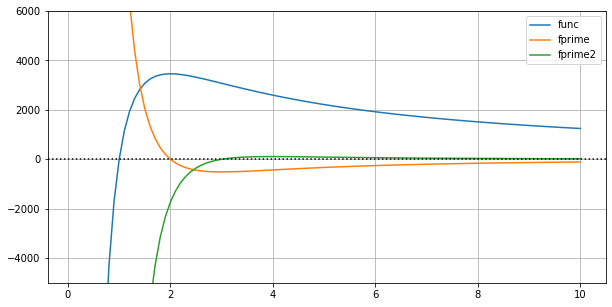

In [136]:
kwargs = {'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
          'as_po': model._as_po, 'ar_po': model._ar_po, 
          'zp_po': model._zp_po, 'dts': model.dt_ik, 
          'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj}

x = np.linspace(0.1, 10.0, 100)
j=0
i=1
n=0
y = [tsvar.models._wold_var.func(e, j=j, i=i, n=n, **kwargs) for e in x]
dy = [tsvar.models._wold_var.fprime(e, j=j, i=i, n=n, **kwargs) for e in x]
ddy = [tsvar.models._wold_var.fprime2(e, j=j, i=i, n=n, **kwargs) for e in x]

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x, y, c='C0', label='func')
plt.plot(x, dy, c='C1', label="fprime")
plt.plot(x, ddy, c='C2', label='fprime2')
plt.legend()
plt.ylim(-5000.0, 6000.0)
plt.axhline(0.0, c='k', ls=':')

In [139]:
j = 0
i = 0
n = 2

kwargs = {
    'j': j, 'i': i, 'n': n,
    'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
    'as_po': model._as_po, 'ar_po': model._ar_po, 
    'zp_po': model._zp_po, 'dts': model.dt_ik, 
    'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj
}

x_start = np.array([
    [ 3.99,  2.40],
    [ 2.99,  2.20],
])

tsvar.models._wold_var.solve_halley(
    tsvar.models._wold_var.func,
    tsvar.models._wold_var.fprime,
    tsvar.models._wold_var.fprime2,
    x0=x_start[j, i],
    max_iter=100,
    tol=1e-5,
    **kwargs)

(nan, False)

---

## Plot exact and approximated densities of $\beta$

In [407]:
# Set model & add observations
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)


In [408]:
beta_range = np.linspace(0.01, 5.0, 110)

i = 0
j = 0

true_post = tsvar.models._wold_var.exact_beta_density(
    beta_range=beta_range,
    bs_pr=10.0,  # beta shape
    br_pr=10.0,  # beta rate
    as_po=0.2,  # alpha shape
    ar_po=1.0,  # alpha rate
    zp_po=0.33 * np.ones(model.n_jumps[i]),  # Uniform Z p=0.33 for all
    dts=model.dt_ik[i],
    delta=model.delta_ikj[i][:, j+1],
    valid_mask=model.valid_mask_ikj[i][:,j+1])

true_post

array([ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01,  0.02,  0.03,  0.04,  0.05,  0.05,  0.06,  0.06,  0.06,  0.06,  0.06,  0.05,  0.05,  0.04,  0.04,  0.04,  0.03,  0.03,  0.03,  0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
        0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00])

In [409]:
approx_post = tsvar.models._wold_var.approx_beta_density(
    beta_range=beta_range, 
    j=j, i=i, 
    x0=1.0, xn=1.0, n=2, 
    
    as_po=0.2 * np.ones((3, 2)), 
    ar_po=1.0 * np.ones((3, 2)), 
    
    zp_po=[0.33 * np.ones((model.n_jumps[i], 3))], 
    
    bs_pr=10.0 * np.ones((2, 2)), 
    br_pr=10.0 * np.ones((2, 2)), 
    
    dt_ik=model.dt_ik, 
    delta_ikj=model.delta_ikj, 
    valid_mask_ikj=model.valid_mask_ikj)

10.000000099000001 10.000000100000001


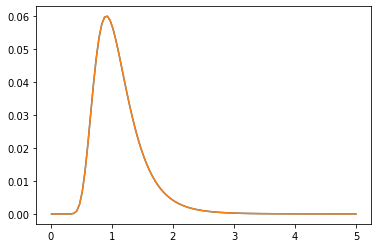

In [410]:
plt.plot(beta_range, true_post)
plt.plot(beta_range, approx_post)

---

Show results

In [166]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(alpha.numpy())
print('Estimated:')
print(adjacency_hat)
print()

beta_hat = np.round(model._br_po / (model._bs_po - 1), 2)
print('Beta:')
print('-----')
print('Ground truth:')
print(beta.numpy() * np.ones((dim, dim)) + 1)
print('Estimated:')
print(beta_hat)

Baseline:
---------
Ground truth:
[ 0.30  0.10]
Estimated:
[ 0.31  0.11]

Adjacency:
---------
Ground truth:
[[ 0.70  0.30]
 [ 0.00  1.00]]
Estimated:
[[ 0.65  0.38]
 [ 0.01  0.91]]

Beta:
-----
Ground truth:
[[ 2.00  1.20]
 [ 1.50  1.10]]
Estimated:
[[ 1.91  1.59]
 [ 1.23  1.01]]


In [225]:
model._br_po

array([[ 15621.70,  20014.44],
       [   702.88,    600.98]])

In [226]:
model._bs_po

array([[ 15621.06,  20013.90],
       [   793.38,    674.50]])